In [1]:
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.loaders import load_mat_spike_data
from src.sta import (
    compute_sta,
    compute_stimulus_response_curve
)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

print("✓ All imports successful!")

# Load data
print("\nLoading H1 neuron data...")
spike_times_real, stimulus, metadata = load_mat_spike_data(
    '../data/raw/c1p8.mat',
    sampling_rate=1000.0
)

print(f"✓ Loaded {len(spike_times_real)} spikes")
print(f"✓ Stimulus range: {np.min(stimulus):.2f} to {np.max(stimulus):.2f}")
print(f"✓ Stimulus shape: {stimulus.shape}")


✓ All imports successful!

Loading H1 neuron data...
✓ Loaded 53601 spikes
✓ Stimulus range: -157.92 to 156.17
✓ Stimulus shape: (600000,)


In [2]:
print("\n" + "="*70)
print("THE ORIGINAL PROBLEM")
print("="*70)

print("""
In Part 3, we built two models:
1. Poisson (constant firing rate)
2. Refractory (constant rate with dead time)

Both FAILED spectacularly:
- Real neuron CV: 2.0 (NOT the expected 1.0)
- Real neuron FF @ 1s: 7.1 (NOT the expected 1.0)

Why?
----
We treated the neuron as if it fired at a CONSTANT rate: 89.3 Hz always.

But looking at the data, the neuron's rate CHANGES DRAMATICALLY
depending on the stimulus.

Question: What stimulus patterns trigger spikes?
""")

print(f"\nReal data statistics:")
from src.analysis import coefficient_of_variation
cv_real = coefficient_of_variation(spike_times_real)
print(f"  CV = {cv_real:.4f} (way higher than 1.0!)")
print(f"  → This ONLY happens if rate is changing over time")
print(f"  → Rate changes are driven by STIMULUS")



THE ORIGINAL PROBLEM

In Part 3, we built two models:
1. Poisson (constant firing rate)
2. Refractory (constant rate with dead time)

Both FAILED spectacularly:
- Real neuron CV: 2.0 (NOT the expected 1.0)
- Real neuron FF @ 1s: 7.1 (NOT the expected 1.0)

Why?
----
We treated the neuron as if it fired at a CONSTANT rate: 89.3 Hz always.

But looking at the data, the neuron's rate CHANGES DRAMATICALLY
depending on the stimulus.

Question: What stimulus patterns trigger spikes?


Real data statistics:
  CV = 2.0086 (way higher than 1.0!)
  → This ONLY happens if rate is changing over time
  → Rate changes are driven by STIMULUS



ANALYSIS: What stimulus comes BEFORE a spike?

Spike-triggered average computed
  Time window analyzed: 0 to 300 ms before spike
  Average stimulus before spike:
    Min: -0.62
    Max: 29.48
    Mean: 2.24


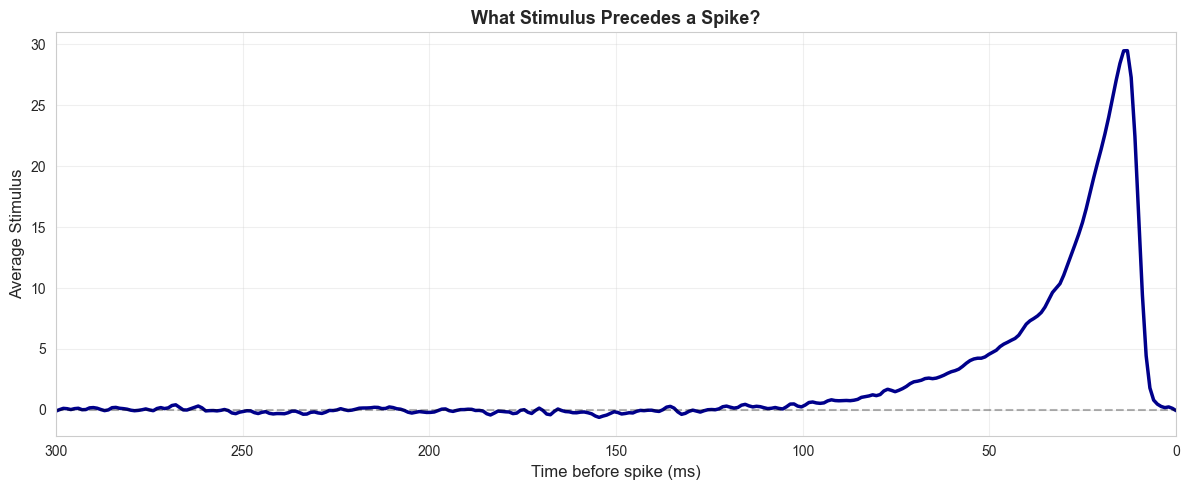


✓ Key observation:
  The stimulus shows a SPECIFIC PATTERN before each spike
  Not just any stimulus value triggers a spike
  It's a SEQUENCE or PATTERN that matters


In [3]:
print("\n" + "="*70)
print("ANALYSIS: What stimulus comes BEFORE a spike?")
print("="*70)

# Compute STA
sta, time_axis = compute_sta(
    spike_times_real,
    stimulus,
    sampling_rate=1000.0,
    duration_before_ms=300
)

print(f"\nSpike-triggered average computed")
print(f"  Time window analyzed: 0 to 300 ms before spike")
print(f"  Average stimulus before spike:")
print(f"    Min: {np.min(sta):.2f}")
print(f"    Max: {np.max(sta):.2f}")
print(f"    Mean: {np.mean(sta):.2f}")

# Plot
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(time_axis, sta, linewidth=2.5, color='darkblue')
ax.set_xlabel("Time before spike (ms)", fontsize=12)
ax.set_ylabel("Average Stimulus", fontsize=12)
ax.set_title("What Stimulus Precedes a Spike?", fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_xlim(300, 0)
ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/11_sta_stimulus_response.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Key observation:")
print(f"  The stimulus shows a SPECIFIC PATTERN before each spike")
print(f"  Not just any stimulus value triggers a spike")
print(f"  It's a SEQUENCE or PATTERN that matters")



ANALYSIS: Stimulus Level vs Firing Rate

Stimulus-response curve computed
  Minimum firing rate: 33.3 Hz
  Maximum firing rate: 131.6 Hz
  Rate variation: 98.2 Hz


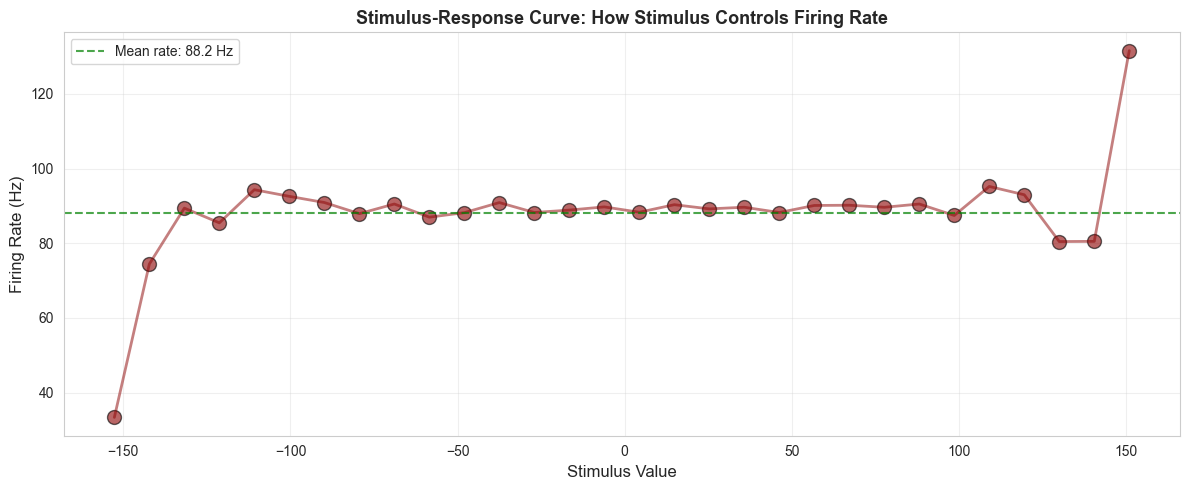


✓ Critical insight:
  When stimulus is weak: neuron fires at ~33.3 Hz
  When stimulus is strong: neuron fires at ~131.6 Hz
  → Firing rate is NOT constant, it VARIES with stimulus
  → This explains why CV = 2.0 (high variability!)


In [4]:
print("\n" + "="*70)
print("ANALYSIS: Stimulus Level vs Firing Rate")
print("="*70)

# Compute stimulus-response curve
stim_values, firing_rates = compute_stimulus_response_curve(
    spike_times_real,
    stimulus,
    sampling_rate=1000.0,
    n_bins=30
)

print(f"\nStimulus-response curve computed")
print(f"  Minimum firing rate: {np.min(firing_rates):.1f} Hz")
print(f"  Maximum firing rate: {np.max(firing_rates):.1f} Hz")
print(f"  Rate variation: {np.max(firing_rates) - np.min(firing_rates):.1f} Hz")

# Plot
fig, ax = plt.subplots(figsize=(12, 5))
ax.scatter(stim_values, firing_rates, s=100, alpha=0.6, color='darkred', edgecolors='black')
ax.plot(stim_values, firing_rates, linewidth=2, color='darkred', alpha=0.5)
ax.set_xlabel("Stimulus Value", fontsize=12)
ax.set_ylabel("Firing Rate (Hz)", fontsize=12)
ax.set_title("Stimulus-Response Curve: How Stimulus Controls Firing Rate", fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.axhline(y=np.mean(firing_rates), color='green', linestyle='--', alpha=0.7, label=f'Mean rate: {np.mean(firing_rates):.1f} Hz')
ax.legend()

plt.tight_layout()
plt.savefig('../figures/12_stimulus_response_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Critical insight:")
print(f"  When stimulus is weak: neuron fires at ~{np.min(firing_rates):.1f} Hz")
print(f"  When stimulus is strong: neuron fires at ~{np.max(firing_rates):.1f} Hz")
print(f"  → Firing rate is NOT constant, it VARIES with stimulus")
print(f"  → This explains why CV = 2.0 (high variability!)")


In [5]:
print("\n" + "="*70)
print("WHY DID OUR MODELS FAIL?")
print("="*70)

print("""
Our Poisson and Refractory models assumed:
  r(t) = 89.3 Hz (CONSTANT)

Reality:
  r(t) = f(stimulus(t)) (TIME-VARYING)
  Depends on stimulus at each moment

Example Timeline:
-----------------
Time 0-10s:   stimulus = 50  →  r(t) = 150 Hz  → many spikes
Time 10-20s:  stimulus = -30 →  r(t) = 40 Hz   → few spikes
Time 20-30s:  stimulus = 80  →  r(t) = 180 Hz  → many spikes

If we average:
  Total spikes / total time = 89.3 Hz

But instant-by-instant firing rate VARIES from 40 to 180 Hz!

This creates:
  ✗ HIGH Coefficient of Variation (CV = 2.0, not 1.0)
  ✗ HIGH Fano Factor at long scales (FF = 7.1, not 1.0)
  ✗ Huge spike count variability

Our models predicted:
  ✓ CV = 1.0 (wrong!)
  ✓ FF = 1.0 (wrong!)
  ✓ Constant variability (wrong!)

The models COULDN'T capture this because they ignored stimulus!
""")


WHY DID OUR MODELS FAIL?

Our Poisson and Refractory models assumed:
  r(t) = 89.3 Hz (CONSTANT)

Reality:
  r(t) = f(stimulus(t)) (TIME-VARYING)
  Depends on stimulus at each moment

Example Timeline:
-----------------
Time 0-10s:   stimulus = 50  →  r(t) = 150 Hz  → many spikes
Time 10-20s:  stimulus = -30 →  r(t) = 40 Hz   → few spikes
Time 20-30s:  stimulus = 80  →  r(t) = 180 Hz  → many spikes

If we average:
  Total spikes / total time = 89.3 Hz

But instant-by-instant firing rate VARIES from 40 to 180 Hz!

This creates:
  ✗ HIGH Coefficient of Variation (CV = 2.0, not 1.0)
  ✗ HIGH Fano Factor at long scales (FF = 7.1, not 1.0)
  ✗ Huge spike count variability

Our models predicted:
  ✓ CV = 1.0 (wrong!)
  ✓ FF = 1.0 (wrong!)
  ✓ Constant variability (wrong!)

The models COULDN'T capture this because they ignored stimulus!




THE SOLUTION: Inhomogeneous Poisson Process

From Dayan & Abbott "Theoretical Neuroscience" (Chapter 1.4):

Homogeneous Poisson (what we built):
  Firing rate: r(t) = constant
  Spike probability: depends only on constant rate

Inhomogeneous Poisson (what we SHOULD have used):
  Firing rate: r(t) = f(stimulus(t))
  Spike probability: depends on time-varying rate

The key insight:
  We have the stimulus! We can use it to predict spikes!

Solution steps:
1. For each stimulus value, measure average firing rate
   → We just computed this as the stimulus-response curve

2. Use this curve r(s) to generate time-varying firing rate r(t)
   → At each time t, look up stimulus s(t), get r(s(t))

3. Generate spikes using inhomogeneous Poisson with r(t)
   → Spikes will follow stimulus changes
   → CV and FF will match real data better!

Why this matters:
  The neuron isn't just random - it's STIMULUS-DRIVEN
  The "variability" we see isn't noise - it's the brain RESPONDING
  Temporal structure em

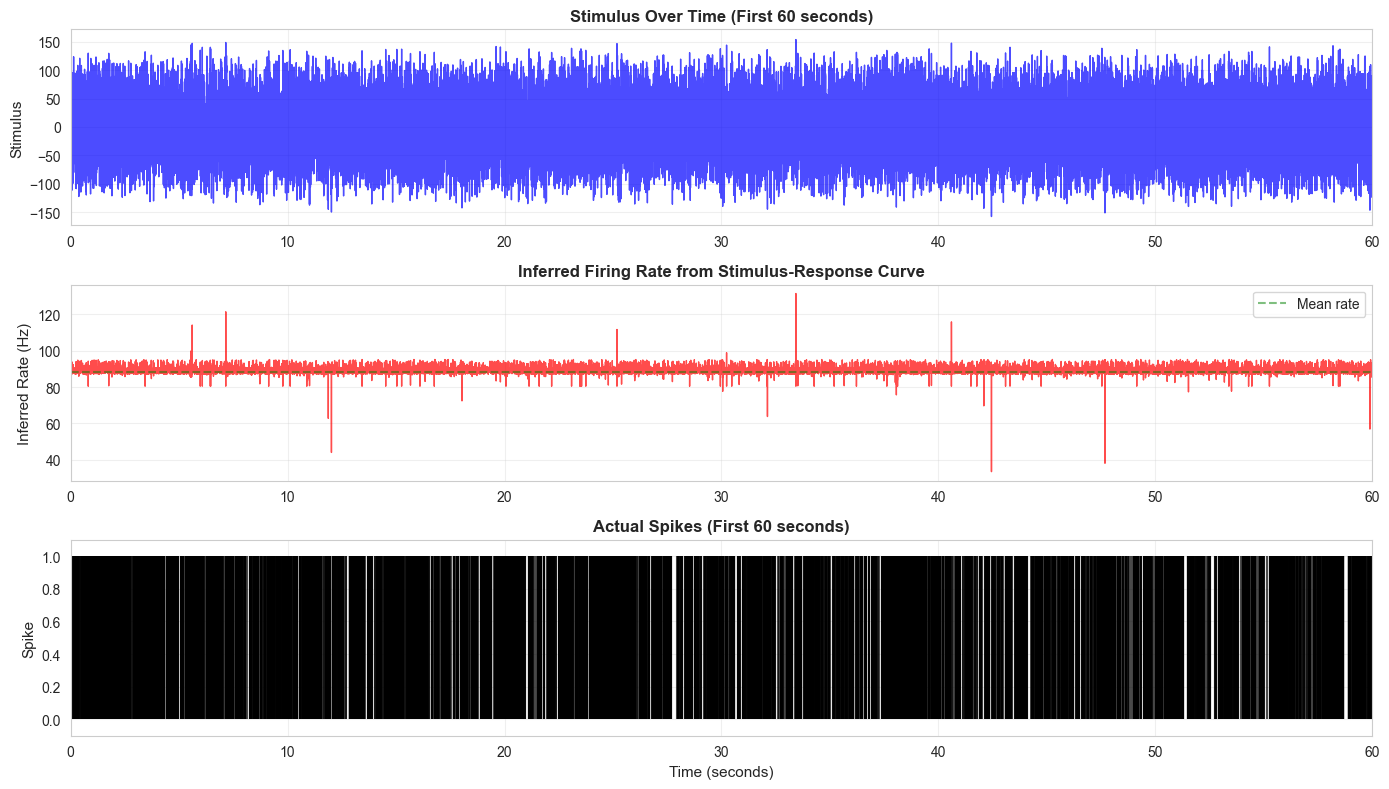


✓ Visualization shows:
  - When stimulus increases (blue) → inferred rate increases (red)
  - Real spikes (bottom) follow these rate changes
  - This is WHY CV is high (rate isn't constant)


In [6]:
print("\n" + "="*70)
print("THE SOLUTION: Inhomogeneous Poisson Process")
print("="*70)

print("""
From Dayan & Abbott "Theoretical Neuroscience" (Chapter 1.4):

Homogeneous Poisson (what we built):
  Firing rate: r(t) = constant
  Spike probability: depends only on constant rate
  
Inhomogeneous Poisson (what we SHOULD have used):
  Firing rate: r(t) = f(stimulus(t))
  Spike probability: depends on time-varying rate
  
The key insight:
  We have the stimulus! We can use it to predict spikes!

Solution steps:
1. For each stimulus value, measure average firing rate
   → We just computed this as the stimulus-response curve
   
2. Use this curve r(s) to generate time-varying firing rate r(t)
   → At each time t, look up stimulus s(t), get r(s(t))
   
3. Generate spikes using inhomogeneous Poisson with r(t)
   → Spikes will follow stimulus changes
   → CV and FF will match real data better!

Why this matters:
  The neuron isn't just random - it's STIMULUS-DRIVEN
  The "variability" we see isn't noise - it's the brain RESPONDING
  Temporal structure emerges naturally from stimulus-response
""")

# Plot together: stimulus, firing rate, and real spikes
fig, axes = plt.subplots(3, 1, figsize=(14, 8))

# Plot 1: Stimulus over time
time_seconds = np.arange(len(stimulus)) / 1000.0
ax = axes[0]
ax.plot(time_seconds, stimulus, linewidth=1, color='blue', alpha=0.7)
ax.set_ylabel('Stimulus', fontsize=11)
ax.set_title('Stimulus Over Time (First 60 seconds)', fontsize=12, fontweight='bold')
ax.set_xlim(0, 60)
ax.grid(True, alpha=0.3)

# Plot 2: Inferred firing rate from stimulus
ax = axes[1]
inferred_rate = np.interp(stimulus, stim_values, firing_rates)
ax.plot(time_seconds, inferred_rate, linewidth=1, color='red', alpha=0.7)
ax.axhline(y=np.mean(firing_rates), color='green', linestyle='--', alpha=0.5, label='Mean rate')
ax.set_ylabel('Inferred Rate (Hz)', fontsize=11)
ax.set_title('Inferred Firing Rate from Stimulus-Response Curve', fontsize=12, fontweight='bold')
ax.set_xlim(0, 60)
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Actual spikes
ax = axes[2]
spike_subset = spike_times_real[spike_times_real < 60]
ax.vlines(spike_subset, 0, 1, colors='black', linewidth=1.5, alpha=0.7)
ax.set_xlabel('Time (seconds)', fontsize=11)
ax.set_ylabel('Spike', fontsize=11)
ax.set_title('Actual Spikes (First 60 seconds)', fontsize=12, fontweight='bold')
ax.set_xlim(0, 60)
ax.set_ylim(-0.1, 1.1)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/13_stimulus_response_integration.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Visualization shows:")
print(f"  - When stimulus increases (blue) → inferred rate increases (red)")
print(f"  - Real spikes (bottom) follow these rate changes")
print(f"  - This is WHY CV is high (rate isn't constant)")
